In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
from boruta import BorutaPy
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

### 1. Import Dataset

In [43]:
data = pd.read_csv("TCGA_InfoWithGrade.csv")
data

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,0,51.30,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,38.72,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,35.17,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,32.78,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,31.51,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,1,1,77.89,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
835,1,0,85.18,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
836,1,1,77.49,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
837,1,0,63.33,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [44]:
data.shape

(839, 24)

In [45]:
data.dtypes

Grade                 int64
Gender                int64
Age_at_diagnosis    float64
Race                  int64
IDH1                  int64
TP53                  int64
ATRX                  int64
PTEN                  int64
EGFR                  int64
CIC                   int64
MUC16                 int64
PIK3CA                int64
NF1                   int64
PIK3R1                int64
FUBP1                 int64
RB1                   int64
NOTCH1                int64
BCOR                  int64
CSMD3                 int64
SMARCA4               int64
GRIN2A                int64
IDH2                  int64
FAT4                  int64
PDGFRA                int64
dtype: object

### 2. Clean Dataset

In [46]:
data.isna().sum()

Grade               0
Gender              0
Age_at_diagnosis    0
Race                0
IDH1                0
TP53                0
ATRX                0
PTEN                0
EGFR                0
CIC                 0
MUC16               0
PIK3CA              0
NF1                 0
PIK3R1              0
FUBP1               0
RB1                 0
NOTCH1              0
BCOR                0
CSMD3               0
SMARCA4             0
GRIN2A              0
IDH2                0
FAT4                0
PDGFRA              0
dtype: int64

In [47]:
# finding duplicates
# So there two duplicaates here, of which, we decided to keep the first instance of each duplicate record. 
# False would eliminate all the records leading to loss of information
data = data.drop_duplicates(keep = "first")
data.shape

(838, 24)

In [48]:
# Closer the std to mean, states that the data is centered around mean
# 50% - The 50th percentile is the median of the dataset 
# If the mean is equal to median then the data is symmetric and no significant skewness
# If the mean > median, the data is rightly skewed and if median> mean, the data is left skewed
# We can overall get an idea of data distribution and understand what tranformations to conduct or not to conduct
data.describe()

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
count,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,...,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000
mean,0.420048,0.418854,50.954212,0.107399,0.480907,0.414081,0.257757,0.168258,0.133652,0.132458,...,0.053699,0.047733,0.045346,0.034606,0.032220,0.032220,0.032220,0.027446,0.027446,0.026253
std,0.493861,0.493666,15.702264,0.369594,0.499934,0.492857,0.437660,0.374318,0.340481,0.339191,...,0.225558,0.213327,0.208186,0.182889,0.176688,0.176688,0.176688,0.163477,0.163477,0.159982
min,0.000000,0.000000,14.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,38.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,51.555000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,62.815000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,89.290000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. Exploaratory Data Analysis 


In [49]:
data__ = data.copy()

#### 1. Conducting Correlation

<AxesSubplot:title={'center':'Feature Correlation'}>

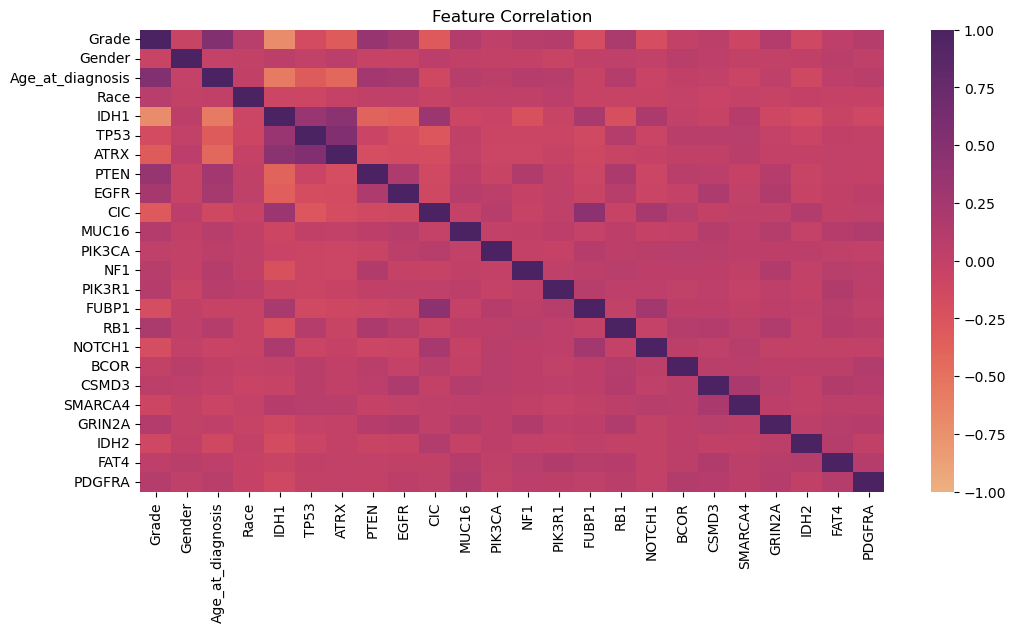

In [50]:
plt.figure(figsize = (12,6))
data_correlation = sns.heatmap(data__.corr(), vmin=-1, vmax=1, cmap= 'flare')
data_correlation.set_title('Feature Correlation', )
data_correlation

#### 2. Data Visualization

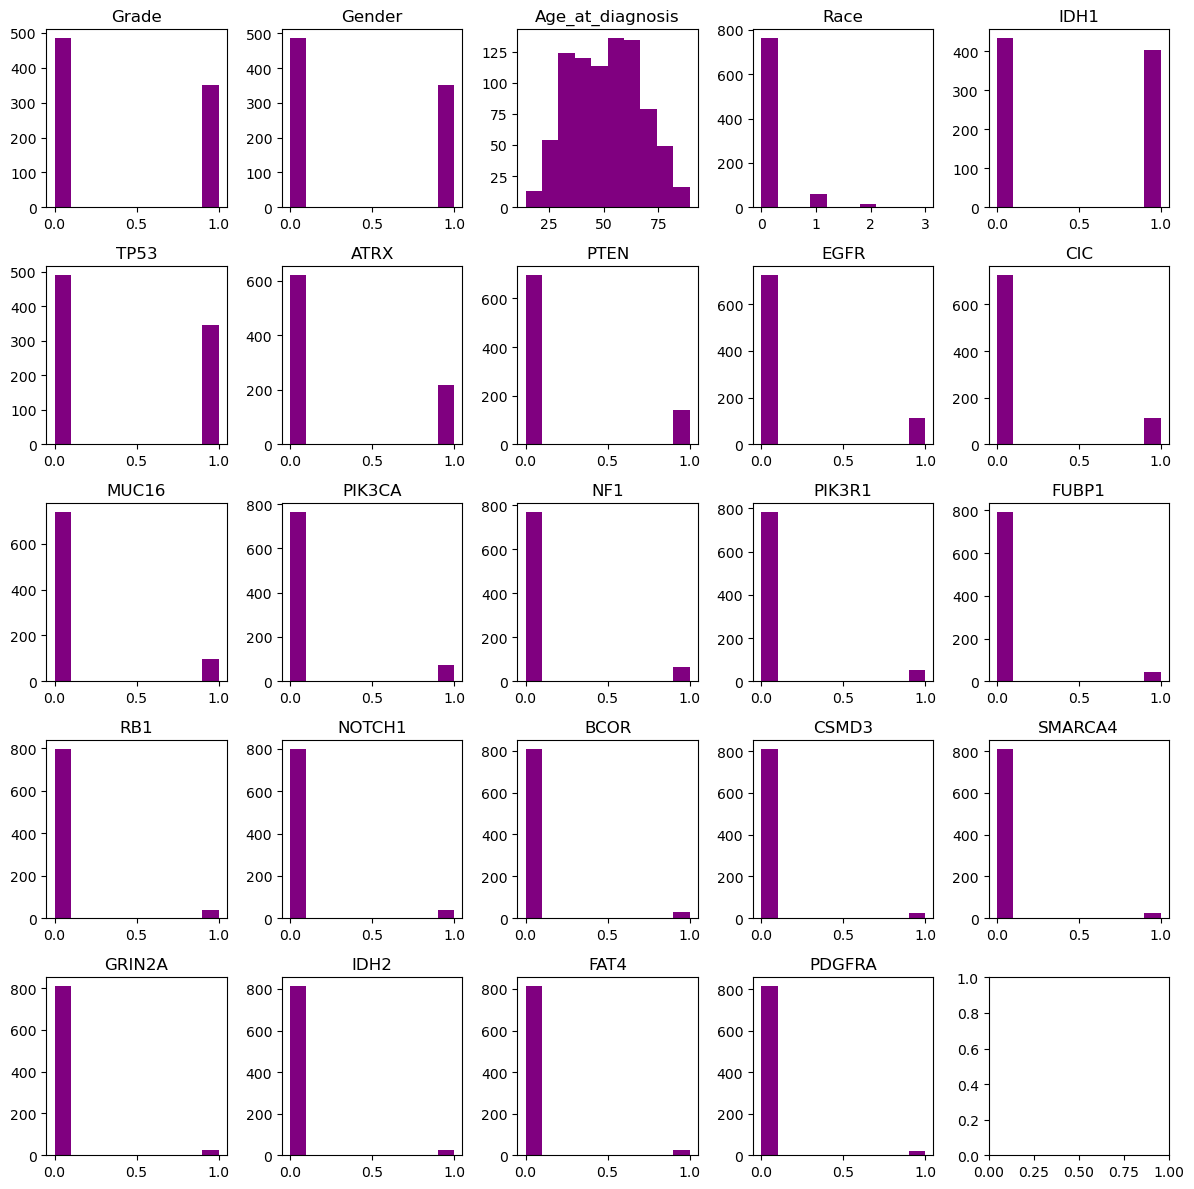

In [51]:
fig, axs = plt.subplots(5,5, figsize = (12,12))
axs = axs.flatten()

for i, column in enumerate (data__.columns):
    axs[i].hist(data__[column], color = "Purple", bins = 10)
    axs[i].set_title(column)
     
plt.tight_layout()
plt.show()
                  
    

#### 3.a. Normalizing Age using MinMax Scaler

In [52]:
# Obtaining age column from dataframe fetches a pandas series. However, the MinMax Scaler expects a 2-D array
age_normal_series = data__["Age_at_diagnosis"]
# The reshape method applies for NumPy array. So we converted the series to NumPy array using values method
age_normal_numpy = age_normal_series.values
# Reshaping the NumPy array to 2D by reshaping the array
age_normal_reshaped = age_normal_numpy.reshape(-1, 1)


normalize = MinMaxScaler()
normalized_age = normalize.fit_transform(age_normal_reshaped)
normalized_age


array([[0.49258715],
       [0.32456258],
       [0.27714705],
       [0.24522506],
       [0.22826232],
       [0.25096835],
       [0.27741418],
       [0.40376653],
       [0.26098571],
       [0.96941365],
       [0.50060104],
       [0.53212235],
       [0.50981702],
       [0.43969547],
       [0.2663283 ],
       [0.34873781],
       [0.5281154 ],
       [0.35755309],
       [0.38760518],
       [0.30746627],
       [0.44143182],
       [0.22171764],
       [0.14825698],
       [0.70014692],
       [0.56444504],
       [0.28809937],
       [0.50180313],
       [0.30279151],
       [0.5353279 ],
       [0.23761186],
       [0.67663951],
       [0.38653666],
       [0.49071724],
       [0.38987578],
       [0.14919193],
       [0.40937625],
       [0.48083344],
       [0.17403499],
       [0.52450915],
       [0.42700681],
       [0.13663684],
       [0.2640577 ],
       [0.20195005],
       [0.4129825 ],
       [0.63884066],
       [0.42994524],
       [0.29731535],
       [0.642

#### 3.b Replacing the normalized age column in the dataset

In [53]:
data__["Age_at_diagnosis"] = normalized_age
data__

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,0,0.492587,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0.324563,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.277147,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0.245225,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0.228262,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,1,1,0.847736,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
835,1,0,0.945105,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
836,1,1,0.842393,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
837,1,0,0.653266,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


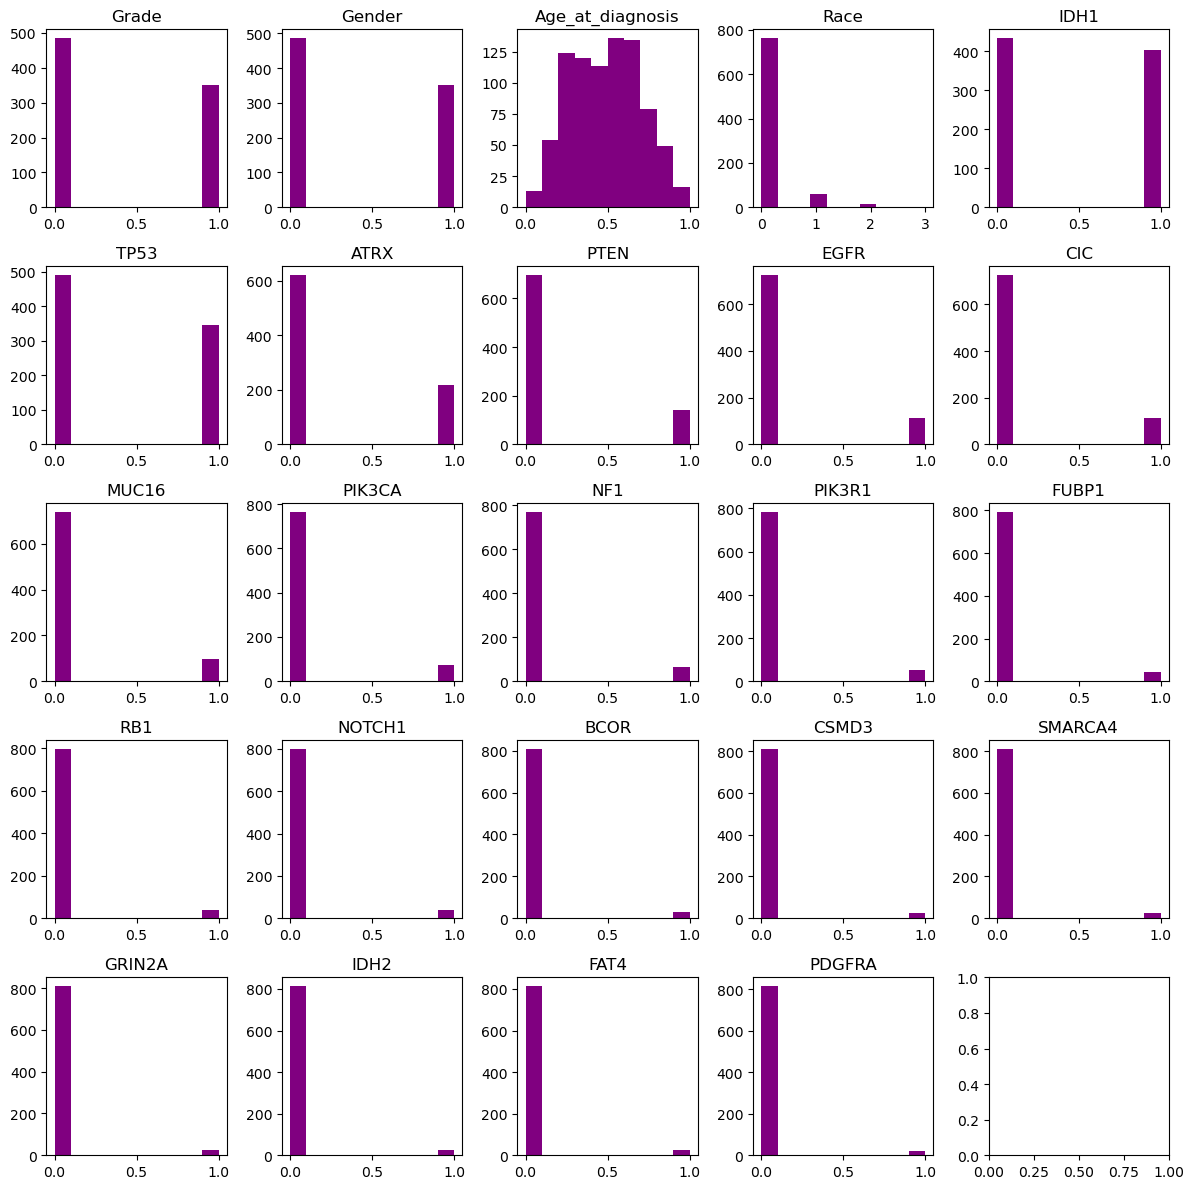

In [54]:
fig, axs = plt.subplots(5,5, figsize = (12,12))
axs = axs.flatten()

for i, column in enumerate(data__.columns):
    axs[i].hist(data__[column], color = "Purple", bins = 10)
    axs[i].set_title(column)
    
plt.tight_layout()
plt.show()

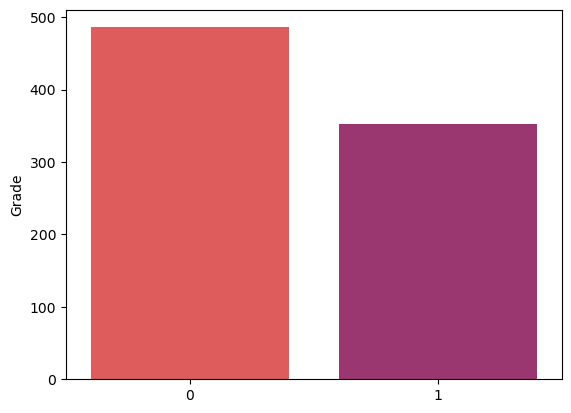

In [55]:
diagnosis_distribution = data['Grade'].value_counts()
barplot = sns.barplot(x=diagnosis_distribution.index, y=diagnosis_distribution, palette="flare", saturation= 1.5,dodge= False)

In [56]:
data = data__.copy()

### 4. Train/Test Split

In [57]:
X = data.iloc[:, 1:]
y = data.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, shuffle = True, stratify = y)

### 5.  Create a baseline model

0.8659271684977811
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.92      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.88      0.87      0.87       252



/Users/kimaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


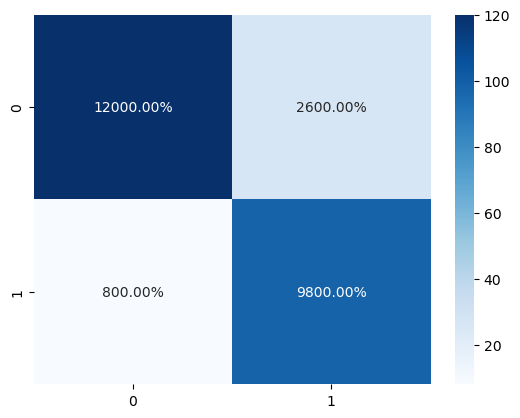

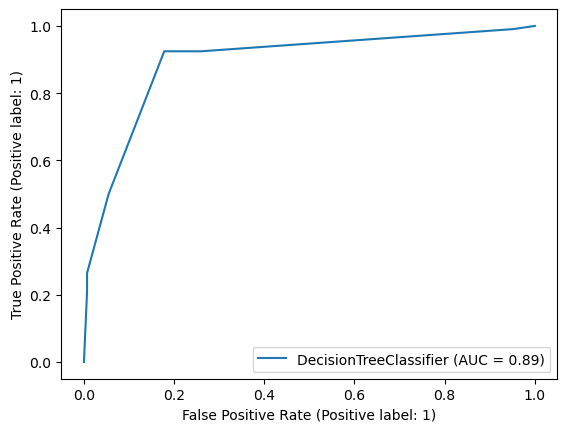

In [68]:
# Initializing RandomForest Classifier
dt_clf = DecisionTreeClassifier(criterion= 'gini', max_depth= 5, splitter = 'best')

# Training the classifier on all features
dt_clf.fit(X_train, y_train)

# Making predictions
y_test_pred = dt_clf.predict(X_test)

# Evaluating model based on f1_score
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f1)

conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix_sb = sns.heatmap(conf_matrix, annot=True, 
            fmt='.2%', cmap='Blues')

model_report = classification_report(y_test, y_test_pred)
print(model_report)

# Plotting a AUC
metrics.plot_roc_curve(dt_clf, X_test, y_test) 

### 6. Checking and Handling Data Imbalance

#### 6.a SMOTE Method

In [69]:
sm = SMOTE(random_state = 42, k_neighbors = 5, sampling_strategy= "auto")
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

#### 6.b. Creating a baseline model after balacing the data- Decision Tree

F1_score= 0.8458149779735683
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       146
           1       0.79      0.91      0.85       106

    accuracy                           0.86       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.87      0.86      0.86       252



/Users/kimaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


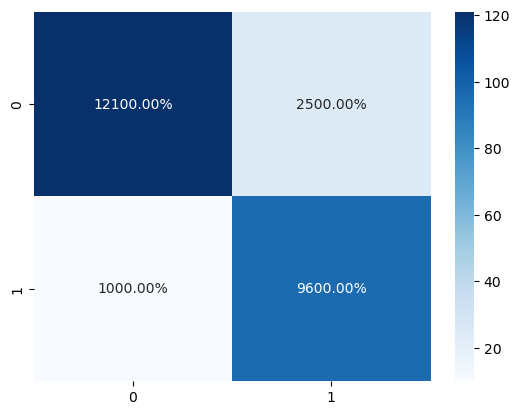

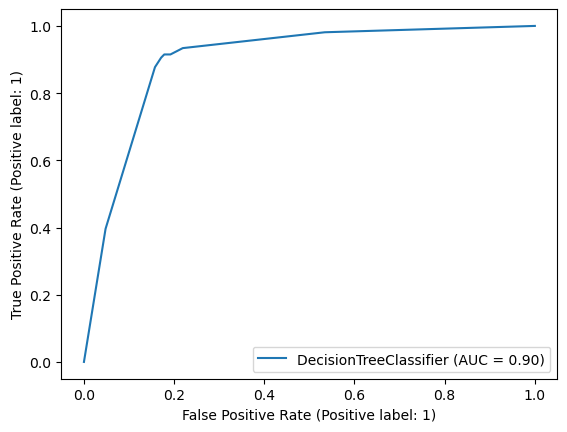

In [70]:
# Initializing RandomForest Classifier
dt_clf = DecisionTreeClassifier(criterion= 'gini', max_depth= 5, splitter = 'best')

# Training the classifier on all features
dt_clf.fit(X_train_sm, y_train_sm)

# Making predictions
y_test_pred = dt_clf.predict(X_test)

# Evaluating model based on f1_score
f1 = f1_score(y_test, y_test_pred)
print("F1_score=", f1)

conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix_sb = sns.heatmap(conf_matrix, annot=True, 
            fmt='.2%', cmap='Blues')

model_report = classification_report(y_test, y_test_pred)
print(model_report)

metrics.plot_roc_curve(dt_clf, X_test, y_test) 


### 7. Feature Selection

#### a. Recursive Feature Elimation using Decision Tree Classifier

k =  1
F1 score =  0.85
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       146
           1       0.77      0.92      0.84       106

    accuracy                           0.85       252
   macro avg       0.85      0.86      0.85       252
weighted avg       0.86      0.85      0.85       252



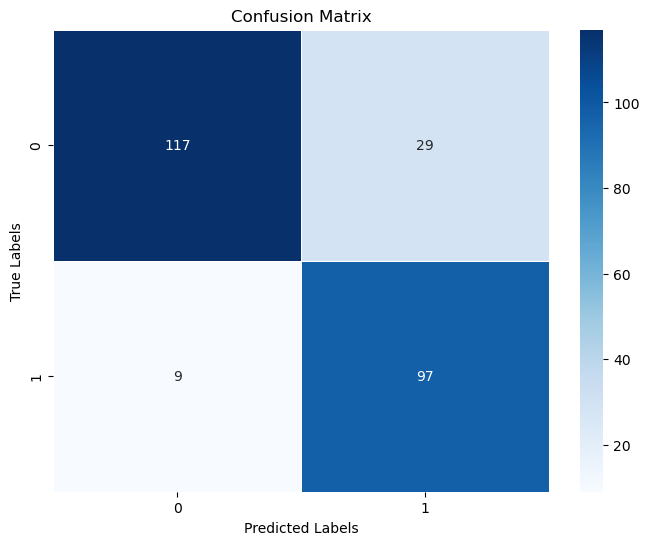

IDH1

k =  2
F1 score =  0.85
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       146
           1       0.77      0.91      0.83       106

    accuracy                           0.85       252
   macro avg       0.85      0.86      0.85       252
weighted avg       0.86      0.85      0.85       252



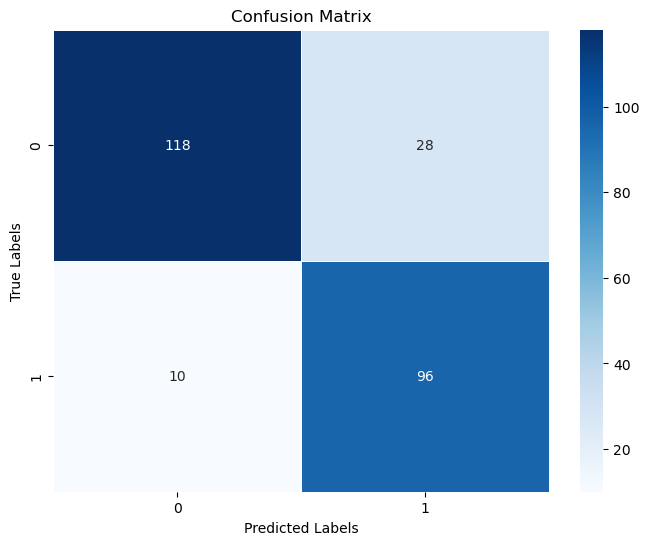

Age_at_diagnosis
IDH1

k =  3
F1 score =  0.854
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       146
           1       0.78      0.92      0.84       106

    accuracy                           0.85       252
   macro avg       0.85      0.86      0.85       252
weighted avg       0.86      0.85      0.85       252



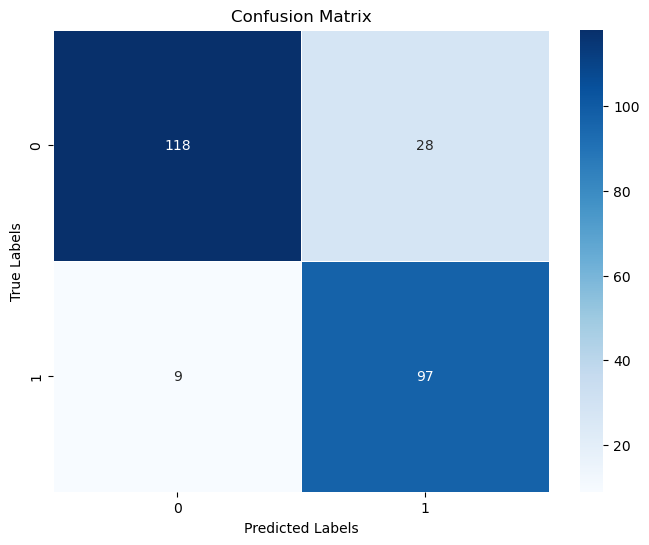

Age_at_diagnosis
IDH1
IDH2

k =  4
F1 score =  0.862
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       146
           1       0.79      0.92      0.85       106

    accuracy                           0.86       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.87      0.86      0.86       252



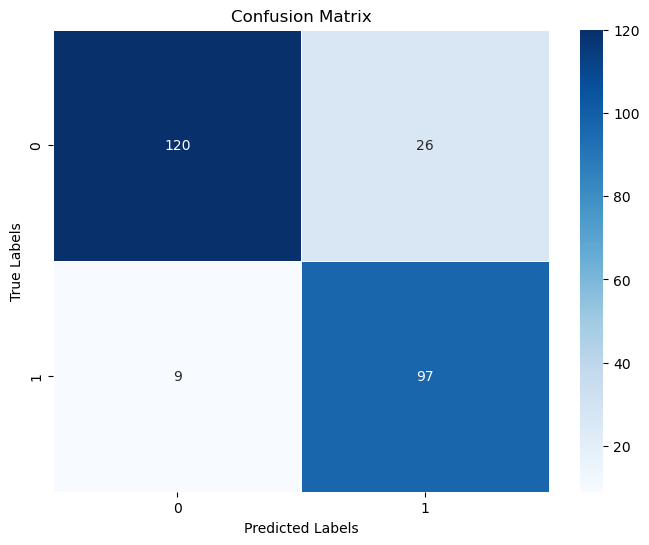

Age_at_diagnosis
IDH1
GRIN2A
IDH2

k =  5
F1 score =  0.858
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       146
           1       0.78      0.92      0.84       106

    accuracy                           0.86       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.87      0.86      0.86       252



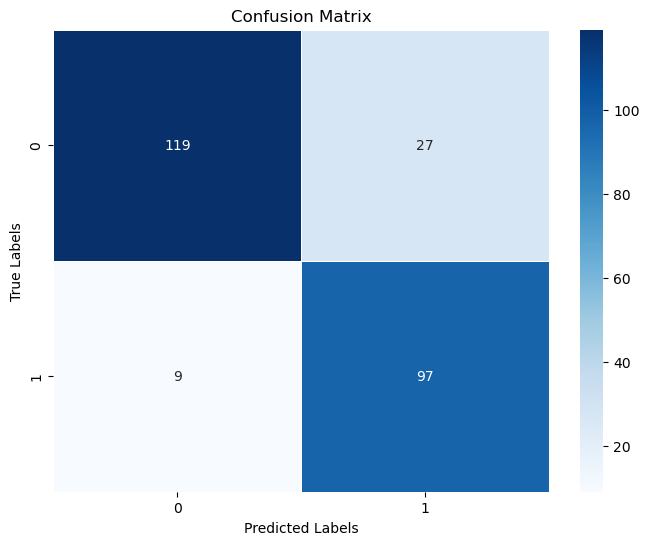

Age_at_diagnosis
IDH1
NOTCH1
GRIN2A
IDH2

k =  6
F1 score =  0.858
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       146
           1       0.78      0.92      0.84       106

    accuracy                           0.86       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.87      0.86      0.86       252



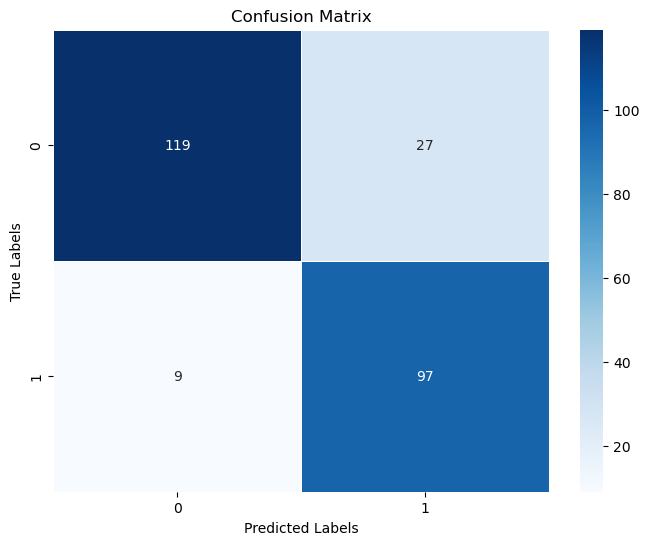

Age_at_diagnosis
IDH1
MUC16
NOTCH1
GRIN2A
IDH2

k =  7
F1 score =  0.862
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       146
           1       0.79      0.92      0.85       106

    accuracy                           0.86       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.87      0.86      0.86       252



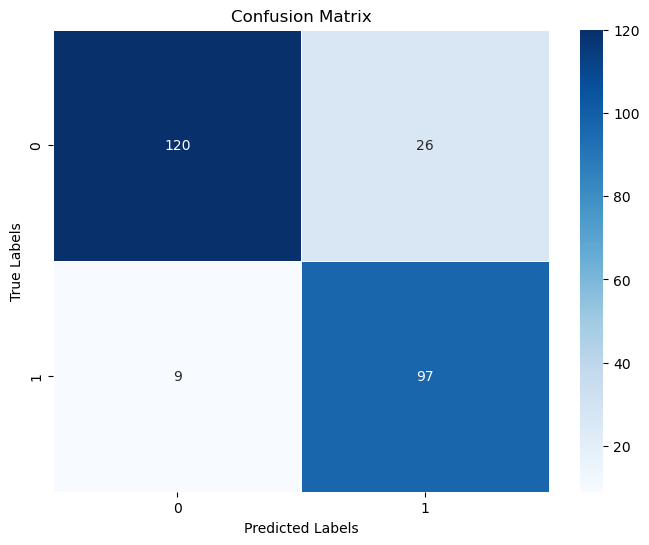

Age_at_diagnosis
IDH1
MUC16
PIK3CA
NOTCH1
GRIN2A
IDH2

k =  8
F1 score =  0.866
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.92      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.88      0.87      0.87       252



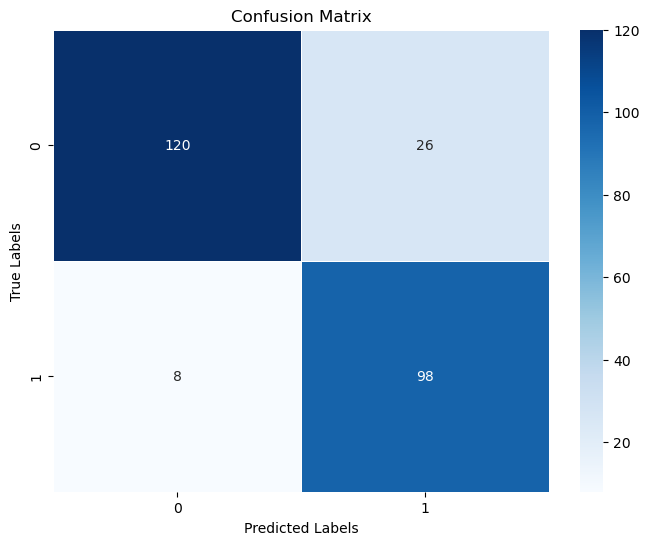

Age_at_diagnosis
Race
IDH1
PTEN
MUC16
NOTCH1
GRIN2A
IDH2

k =  9
F1 score =  0.866
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.92      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.88      0.87      0.87       252



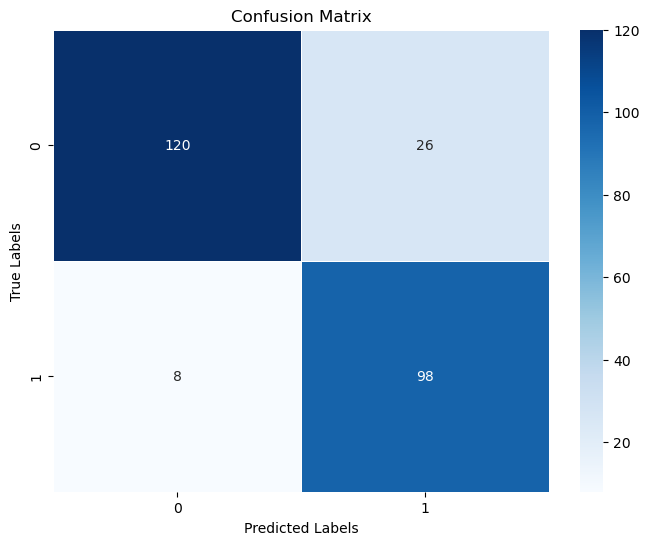

Age_at_diagnosis
Race
IDH1
PTEN
MUC16
PIK3CA
NOTCH1
GRIN2A
IDH2

k =  10
F1 score =  0.866
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.92      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.88      0.87      0.87       252



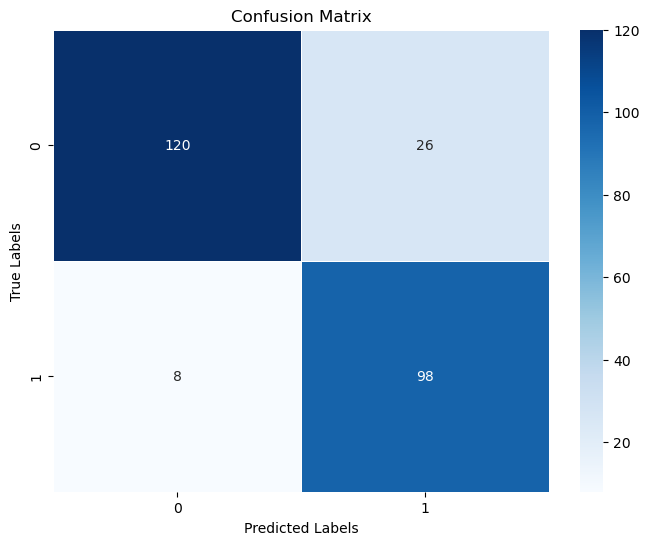

Age_at_diagnosis
Race
IDH1
PTEN
EGFR
MUC16
NOTCH1
GRIN2A
IDH2
PDGFRA

k =  11
F1 score =  0.866
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.92      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.88      0.87      0.87       252



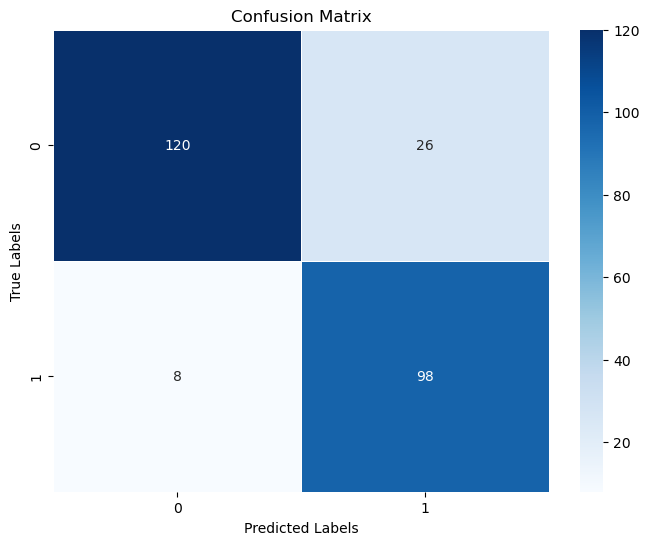

Age_at_diagnosis
Race
IDH1
PTEN
EGFR
MUC16
PIK3CA
NOTCH1
GRIN2A
IDH2
PDGFRA

k =  12
F1 score =  0.87
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.93      0.86       106

    accuracy                           0.87       252
   macro avg       0.87      0.88      0.87       252
weighted avg       0.88      0.87      0.87       252



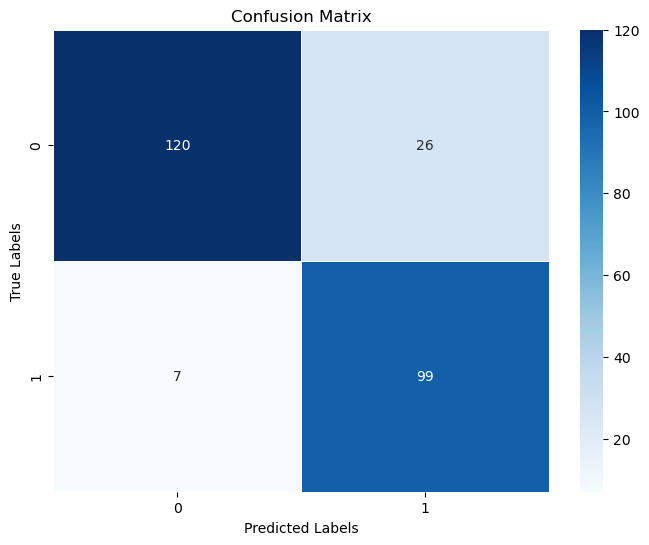

Age_at_diagnosis
Race
IDH1
ATRX
PTEN
EGFR
MUC16
NF1
NOTCH1
GRIN2A
IDH2
PDGFRA

k =  13
F1 score =  0.87
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.93      0.86       106

    accuracy                           0.87       252
   macro avg       0.87      0.88      0.87       252
weighted avg       0.88      0.87      0.87       252



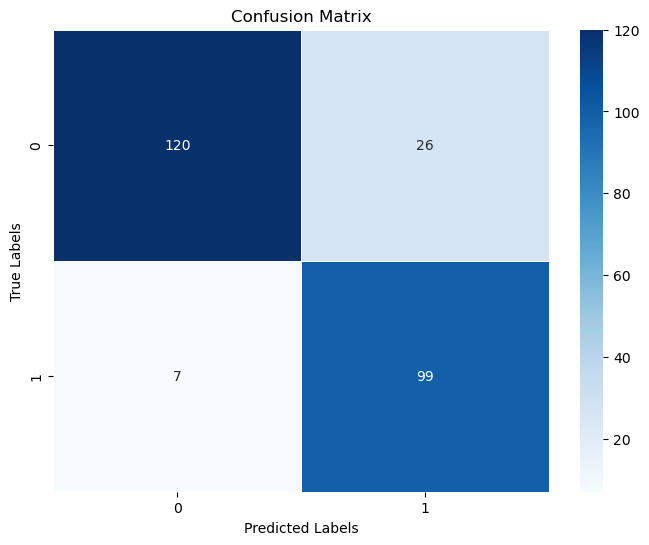

Age_at_diagnosis
Race
IDH1
TP53
PTEN
EGFR
MUC16
PIK3CA
PIK3R1
NOTCH1
GRIN2A
IDH2
PDGFRA

k =  14
F1 score =  0.87
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.93      0.86       106

    accuracy                           0.87       252
   macro avg       0.87      0.88      0.87       252
weighted avg       0.88      0.87      0.87       252



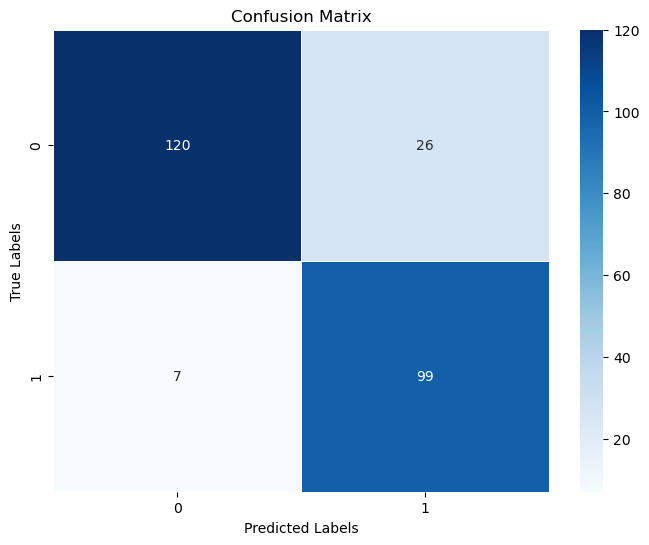

Age_at_diagnosis
Race
IDH1
ATRX
PTEN
EGFR
MUC16
PIK3CA
PIK3R1
NOTCH1
GRIN2A
IDH2
FAT4
PDGFRA

k =  15
F1 score =  0.866
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.92      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.88      0.87      0.87       252



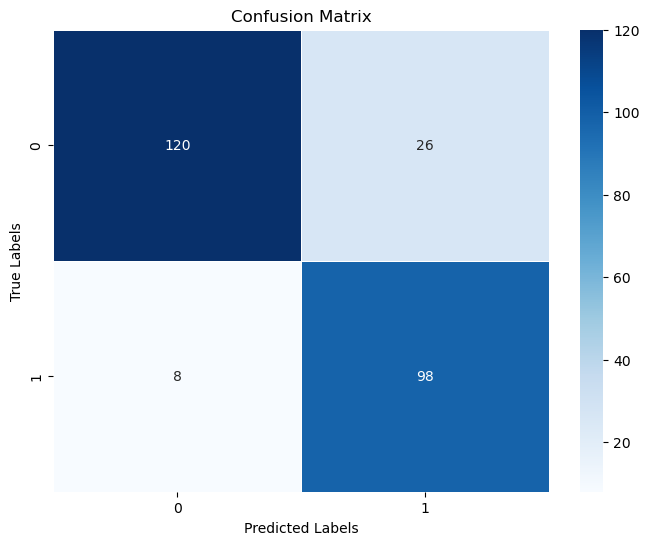

Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
MUC16
PIK3CA
NF1
NOTCH1
GRIN2A
IDH2
FAT4
PDGFRA

k =  16
F1 score =  0.87
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.93      0.86       106

    accuracy                           0.87       252
   macro avg       0.87      0.88      0.87       252
weighted avg       0.88      0.87      0.87       252



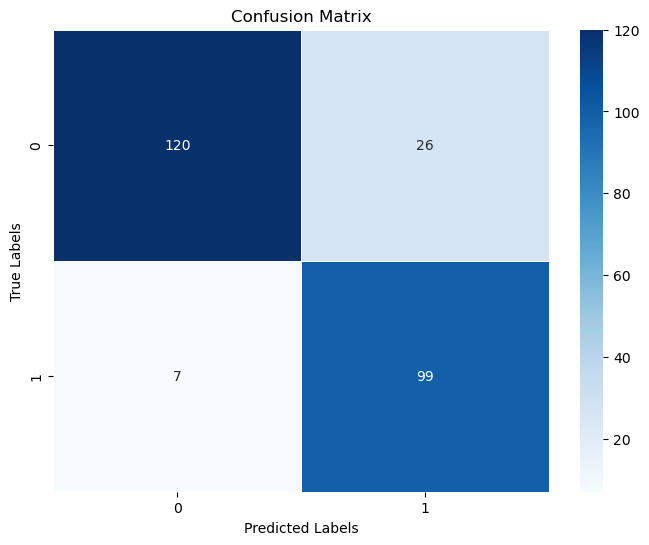

Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
PIK3CA
PIK3R1
NOTCH1
GRIN2A
IDH2
FAT4
PDGFRA

k =  17
F1 score =  0.87
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       146
           1       0.80      0.92      0.86       106

    accuracy                           0.87       252
   macro avg       0.87      0.88      0.87       252
weighted avg       0.88      0.87      0.87       252



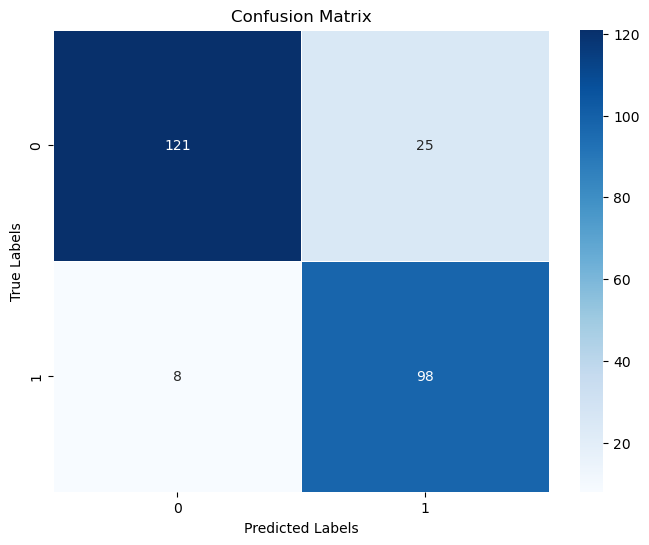

Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
PIK3CA
NF1
PIK3R1
NOTCH1
GRIN2A
IDH2
FAT4
PDGFRA

k =  18
F1 score =  0.866
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.92      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.88      0.87      0.87       252



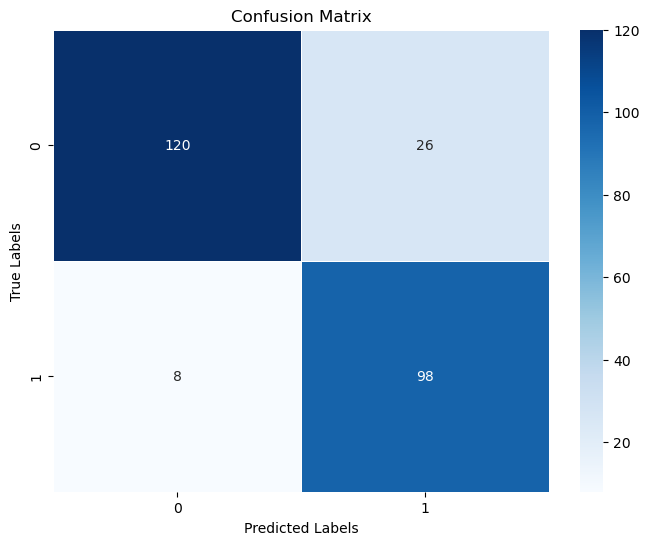

Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
PIK3CA
PIK3R1
FUBP1
RB1
NOTCH1
GRIN2A
IDH2
FAT4
PDGFRA

k =  19
F1 score =  0.874
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       146
           1       0.80      0.93      0.86       106

    accuracy                           0.87       252
   macro avg       0.87      0.88      0.87       252
weighted avg       0.88      0.87      0.87       252



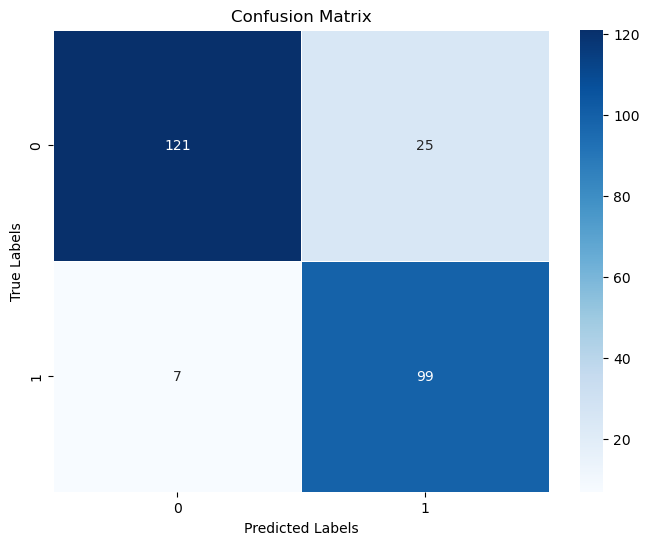

Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
PIK3CA
NF1
PIK3R1
FUBP1
RB1
NOTCH1
GRIN2A
IDH2
FAT4
PDGFRA

k =  20
F1 score =  0.866
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.92      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.88      0.87      0.87       252



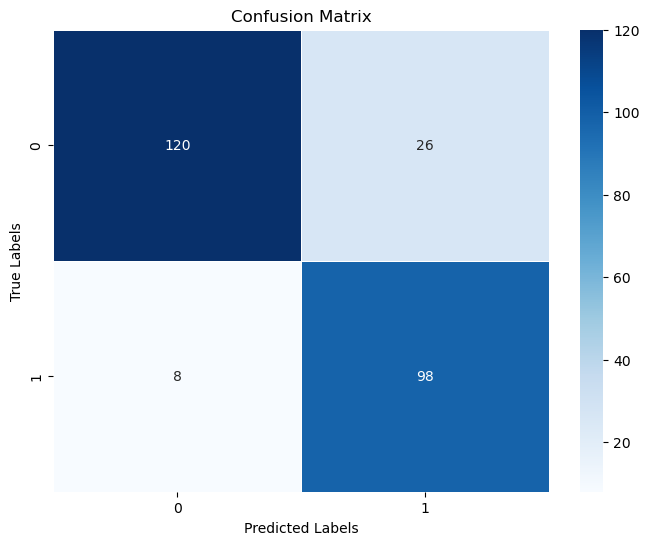

Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
PIK3CA
FUBP1
RB1
NOTCH1
BCOR
CSMD3
SMARCA4
GRIN2A
IDH2
FAT4
PDGFRA

k =  21
F1 score =  0.874
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       146
           1       0.80      0.93      0.86       106

    accuracy                           0.87       252
   macro avg       0.87      0.88      0.87       252
weighted avg       0.88      0.87      0.87       252



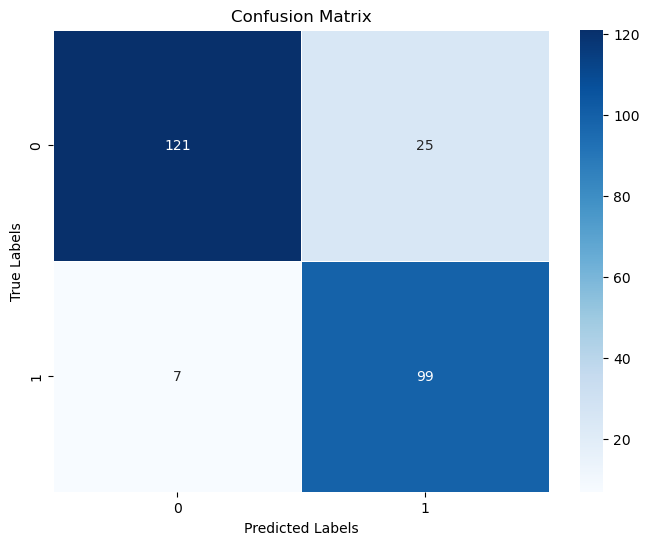

Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
PIK3CA
PIK3R1
FUBP1
RB1
NOTCH1
BCOR
CSMD3
SMARCA4
GRIN2A
IDH2
FAT4
PDGFRA

k =  22
F1 score =  0.866
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.79      0.92      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.88      0.87      0.87       252



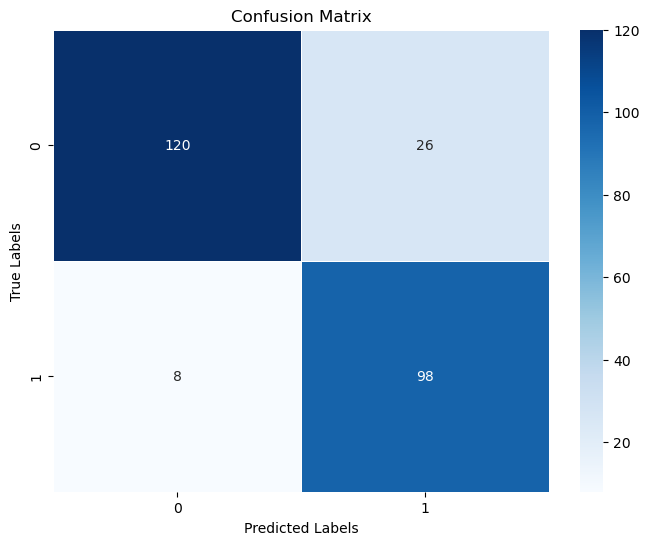

Gender
Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
PIK3CA
NF1
PIK3R1
FUBP1
RB1
NOTCH1
BCOR
CSMD3
GRIN2A
IDH2
FAT4
PDGFRA



In [72]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

dt_clf = DecisionTreeClassifier(criterion= 'gini', max_depth= 5, splitter = 'best')
f1_scores = []

for k in range (1,23):
    RFE_selector = RFE(estimator = dt_clf, n_features_to_select = k, step= 1)
    RFE_selector.fit(X_train_rfe, y_train_rfe)
    
    selected_RFE_X_train = RFE_selector.transform(X_train_rfe)
    selected_RFE_X_test = RFE_selector.transform(X_test_rfe)
    
    dt_clf.fit(selected_RFE_X_train, y_train_rfe)
    RFE_preds = dt_clf.predict(selected_RFE_X_test)
    
    fl_score_rfe = round(f1_score(y_test_rfe, RFE_preds, average='weighted'), 3)
    f1_scores.append(fl_score_rfe)
    
    print("k = ", k)
    print("F1 score = ", fl_score_rfe)

    # Plotting a model report for the model
    model_report = classification_report(y_test_rfe,RFE_preds )
    print(model_report)
    
    # Plotting a confusion matrix for the model
    conf_matrix = confusion_matrix(y_test_rfe, RFE_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
     
    selected_features = RFE_selector.support_
    for feature_name, is_selected in zip(X_train_rfe, selected_features):
        if is_selected == True:
            print(feature_name)
    print()

In [73]:
f1_scores
# average_f1 = sum(f1_scores) / len(f1_scores)
# print("Average F1 Score:", average_f1)

[0.85,
 0.85,
 0.854,
 0.862,
 0.858,
 0.858,
 0.862,
 0.866,
 0.866,
 0.866,
 0.866,
 0.87,
 0.87,
 0.87,
 0.866,
 0.87,
 0.87,
 0.866,
 0.874,
 0.866,
 0.874,
 0.866]

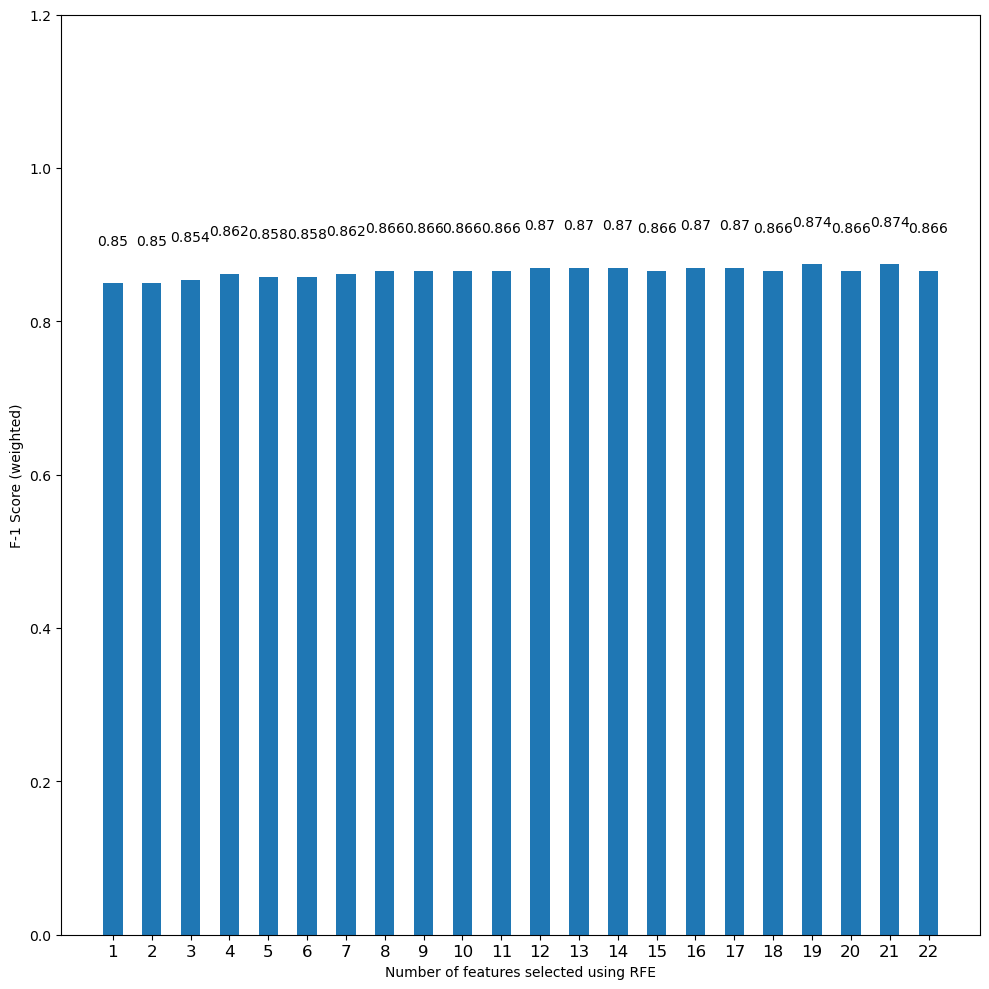

In [74]:
fig,axs = plt.subplots(figsize= (10,10))

x = np.arange(1,23)
y = f1_scores

axs.bar(x,y, width= 0.5)
axs.set_xlabel("Number of features selected using RFE")
axs.set_ylabel("F-1 Score (weighted)")
axs.set_ylim(0,1.2)
axs.set_xticks(np.arange(1, 23))
axs.set_xticklabels(np.arange(1, 23), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')
    
plt.tight_layout()
plt.show()

### b. Boruta Method 

In [94]:
X_train_bor, X_test_bor, y_train_bor, y_test_bor = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

dt_clf = DecisionTreeClassifier(criterion= 'gini',max_depth= 3, splitter = 'best', random_state= 42)
print(dt_clf.get_params().keys())
f1_scores = []

boruta_selector = BorutaPy(dt_clf, random_state=20,alpha=0.05)
boruta_selector.fit(X_train_bor.values, y_train_bor.values.ravel())

selected_Bor_X_train = boruta_selector.transform(X_train_bor.values)
selected_Bor_X_test = boruta_selector.transform(X_test_bor.values)

dt_clf.fit(selected_Bor_X_train, y_train_bor.values)
boruta_preds = dt_clf.predict(selected_Bor_X_test)

fl_score_bor = round(f1_score(y_test_bor.values, boruta_preds, average='weighted'), 3)
f1_scores.append(fl_score_bor)

accuracy = accuracy_score(y_test_bor.values, boruta_preds, normalize= True)
ranking =  boruta_selector.ranking_

print("f1 score = ", fl_score_bor)
print("Accuracy=", accuracy)

for rank, feature in zip(ranking, X_train_bor):
    if rank == 1:
        print(feature)

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])


ValueError: Invalid parameter n_estimators for estimator DecisionTreeClassifier(max_depth=3, random_state=42). Check the list of available parameters with `estimator.get_params().keys()`.

ValueError: shape mismatch: objects cannot be broadcast to a single shape

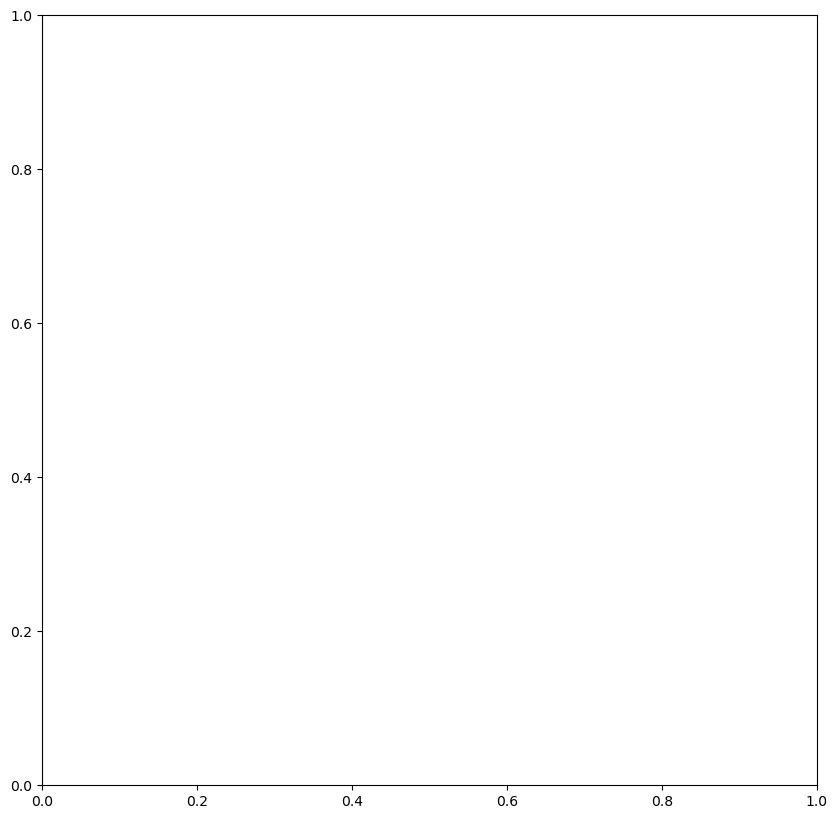

In [39]:
fig,axs = plt.subplots(figsize= (10,10))

x = np.arange(1,23)
y = f1_scores

axs.bar(x,y, width= 0.5)
axs.set_xlabel("Number of features selected using RFE")
axs.set_ylabel("F-1 Score (weighted)")
axs.set_ylim(0,1.2)
axs.set_xticks(np.arange(1, 23))
axs.set_xticklabels(np.arange(1, 23), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')
    
plt.tight_layout()
plt.show()

Baseline model-
f1_score = 0.885
Accuracy = 0.88

Smote- 
f1_score = 0.87
Accuracy = 0.89

RFE-
f1_score- 0.87
Accuracy = 

Boruta-
F1 score =  0.87
Accuracy= 0.869

k = 14
F1- .886
accuracy = 0.85

Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
NF1
PIK3R1
FUBP1
RB1
NOTCH1

k =  15
F1 score =  0.886
Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
NF1
PIK3R1
FUBP1
RB1
NOTCH1
IDH2

Age_at_diagnosis
Race
IDH1
TP53
ATRX
PTEN
EGFR
CIC
MUC16
PIK3CA
NF1
PIK3R1
FUBP1
RB1
NOTCH1
CSMD3
SMARCA4
GRIN2A
IDH2
PDGFRA


In [89]:
boruta_selector = BorutaPy(dt_clf, random_state=20,alpha=0.05)
boruta_selector.get_params().keys()


dict_keys(['alpha', 'estimator__ccp_alpha', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__random_state', 'estimator__splitter', 'estimator', 'max_iter', 'n_estimators', 'perc', 'random_state', 'two_step', 'verbose'])

In [ ]:
criterion, max_depth, 'random_state', 'splitter'